# Initialschätzung von Kurswechselpositionen eines Segelboots auf einer Karte anhang con Wind, Start und Zielpunkt

## Motivation

Ziel dieser Semester abschließenden schriftlichen Ausarbeitung im Fach "Maschine Learning" an der Fachhochschule Südwestfalen ist das Generieren einer Heatmap von Kurswechselpositionen eines Segelbootes zu einer Karte abhängig von Wind und der Zielpostion. Dies soll das Finden einer guten Route vereinfachen, indem die Qualität einer ersten Route, die danach über ein Quotientenabstiegsverfahren optimiert werden soll verbessern. Da ein solches Quotientenabstiegsverfahren sehr gerne in einem Lokalen minimum festhängt, müssen mehrere routen gefunden und optimiert werden. Hier soll untersucht werden, ob dies durch eine Ersteinschätzung der Lage durch KI verbessert werden kann.

Eingesetzt werden soll die so erstellte KI in dem Segelroboter des [Sailing Team Darmstadt e.V.](https://www.st-darmstadt.de/). Einer Hochschulgruppe an der TU-Darmstadt welche den ["roBOOTer"](https://www.st-darmstadt.de/ueber-uns/boote/prototyp-ii/) ein vollautonomes Segelboot welches eines Tages den Atlantik überqueren soll. [Eine technische Herausforderung welche zuerst von einem norwegischen Team erfolgreich abgeschlossen wurde](https://www.microtransat.org/).

## Inhaltsverzeichnis

    1. Einleitung
        1.1. Situation
        1.2. Vorgehen zur Unterstützenden KI
    2. Vorbereitungen
    3. Senarien und Routen Generieren
    4. Daten betrachten und Filtern
    5. KI Modell erstellen
    6. Training
    7. Analyse der KI
    8. Ausblick
    

## Einleitung

### Situation

Eine Routenplanung für ein Segelboot hat ein Problem, welches man sonst so eher nicht kennt. Eine relativ freie Fläche auf der Sich das Schiff bewegen kann. Dies verändert die Wegfindung wie man sie von der Straße kennt fundamental.

Navigiert man auf Straßen, hat man zumindest nach einer ersten abstraction relativ wenige Freiheitsgrade für den Weg.
Die Richtung kann nur an Kreuzungen gewechselt werden und dort nur in Richtungen in die es Straßen gibt. Beim Segeln auf dem freien Meer ist jeder Ort ein Potenzieller Wendpunkt von dem aus Potenziell in jede Richtung gesegelt werden kann.

Dennoch ist es oft auch ohne Hindernisse zwischen Boot und Ziel oft nicht möglich das Ziel direkt anzufahren das sich die Maximalgeschwindigkeiten relativ zur Windrichtung verändern.
Das folgende Diagramm zeigt die Segelgeschwindigkeiten an einem Katamaran.

<img src="https://www.researchgate.net/profile/Hoyun-Jang-2/publication/320062151/figure/fig2/AS:667648312483865@1536191170832/Polar-diagram-of-yacht-speed-according-to-diverse-wind-direction-and-speed.ppm" alt="Ship speeds relativ to the wind" style="width: 400px;"/>

Da der roBOOTer anders als an Katamaran nicht auf Geschwindigkeit, sondern auf mechanische Belastbarkeit ausgelegt wurde hat der Fahrtwind einen geringeren einfluss auf das Fahrtverhalten des Segelboots dies und eine andere Maximalgeschwindigkeit sorgen für ein etwas anderes Fahrverhalten. Die ungefähre Form der Kurven trifft aber auch auf den roBOOTer zu. Man kann deutlich erkennen das auch, wenn man nicht direkt gegen den Wind fahren kann man schräg gegen den wind immer noch erstaunlich schnell ist.

Das aktuelle Verfahren zum Finden einer Route läuft folgendermaßen ab:

Eine direkte Route wird berechnet. Die Route wird an jedem Hindernisse geteilt und rechts und links um jedes hindernis herum gelegt. Bei folgenden hindernissen werden die Routen wieder geteilt somit erhält man $2^n$ Vorschläge für Routen wobei $n$ die Anzahl der Hindernisse auf der Route ist. Jeder Abschnitt der Route wird noch einmal zerteilt, um der Route mehr Flexibilität zu geben.

Die Routen werden dann simuliert, um die Kosten der Route zu berechnen. Die so simulierte Route wird danach über die Kosten in einem Gradientenabstiegsverfahren optimiert.

Das ganze oben beschriebene Verfahren ist relativ schnell sehr rechenaufwendig und findet nicht immer ein Ergebnis. Wird kein Ergebnis gefunden wird eine mehr oder weniger zufällige Route optimiert.

Diese Ausarbeitung soll wenigstens bei der alternativen Routenfindung helfen. Im idealfall kann es aber auch genutzt werden, um die auswahl der Routen um Hindernisse frühzeitig zu reduzieren und den Rechenaufwand unter $2^n$ zu senken wobei $n$ die Anzahl von Hindernissen auf der Route ist.

### Vorgehen zur unterstützenden KI

#### Eingaben und Ausgeben

Die Algorithm zur Wegfindung vom Sailing Team Darmstadt e.V. arbeiten intern mit Polygonen als Hindernissen. Diese werden durch die Shapely Bibliothek implementiert. Da eine variable Anzahl an Polygonen mit einer variablen Form und Position eine Relative komplexer Input muss dieser in eine normierte Form gebracht werden. Ein binärfärbens Bild ist dafür die einfachste Form.

Für den Computer spielen sowohl Zentrierung, Skalierung und Ausrichtung der Karte keine Rolle.
Wir rotieren also die Karte immer so das der Wind von *Norden* kommt und das Boot / die Startposition in der *Mitte* der Karte liegt. Da distanz Liner ist, wird davon ausgegangen das Scenario einfach skaliert passend skaliert werden kann.

Die nächste eingabe ist die Zielposition relativ zum Startpunkt. Diese kann entweder durch ein einzelnes Pixel in einem zweiten Farbkanal oder aber in abstrakterer Form an die KI übergeben werden.

Als ausgabe wird eine Heatmap erwartet. Zwei alternative Heatmaps sind relative einfach denkbar.

1. Eine Headmap der Kurswechselpositionen
2. Eine Headmap des Kursverlaufes

Headmaps sind in gewisser Weise Bilder. Das Problem wird daher wie ein Bild zu Bild KI Problem betrachtet. Diese werden normalerweise durch ANNs gelöst.

Um eine ANN zu trenntieren gibt es immer die Wahl zwischen drei Primären prinzipien. Dem unüberwachten Lernen, dem reinforcement Learning und dem überwachten Lernen. Letzteres ist dabei meist am einfachsten wenn auch nicht immer möglich.

Der Wegfindealgorithmus des Sailing Team Darmstadt e.V. ist zwar noch in der Entwicklung, funktioniert aber hinreichend gut, um auf einem normalen PC Scenarios mit Routen zu paaren oder auch diese zu *labeln*, um beim KI lingo zu bleiben. Um anpassungsfähig an andere Scenarios zu sein wird eine große Menge unterschiedlicher Scenarios und Routen benötigt.
Da das Haupteinsatzgebiet das Meer ist gehen wir von einer Insellandschaft oder Küstenlandschaft aus.

Zum Finden von Scenarios gibt es zwei Möglichkeiten.

1. Das Auswählen von umgebungen von der Weltkarte und das Bestimmen eines Zielpunktes.
2. Das Generieren von künstlichen Scenarios.
 
Hier wird die Annahme getroffen das sich ANNs von einem Datensatz auf dem anderen Übertragen lassen.
Der Aufwand für künstliche Scenarios wird hierbei als geringer eingestuft und daher gewählt.

## Vorbereitungen

Folgende Python Bibliotheken werden verwendet:

1. `Tensorflow`
   Die `Tensorflow` Bibliothek ist das Werkzeug welches verwendet wurde, um neuronale Netz zu modellieren, zu trainieren, zu analysieren und auszuführen.

2. `pyrate`
   Die `Pyrate` Bibliothek ist Teil des ROS Operating Systems, welches den roBOOTer betreibt. Kann Routen zu Scenarios finden.

3. `Shapley`
   Die `shapley` Bibliothek wird genutzt, um geometrische Körper zu generieren, zu mergen und an den Roboter zum Labeln weiterzugeben.

4. `pandas`
   Die `pandas` Bibliothek verwaltet, speichert und analysiert daten.

5. `numpy`
   Eine Bibliothek um Mathematische operations an multidimensionalen Arrays auszuführen.

6. `matplotlib`
   Wird genutzt um Diagramme zu plotted.

6. `PIL`
   Eine Library um Bilder manuell zu zeichnen.

7. `humanize`
   Konvertiert Zahlen, Daten und Zeitabstände in ein für menschen einfach leserliches Format.

8. `tqdm`
   Fügt einen Fortschrittsbalken zu vielen Problemen hinzu.

Definiert den Pfad an dem der Jupyter notebook ausgeführt werden soll.

In [1]:
%cd /pyrate/

/pyrate


#### Imports
Importiert die Imports the necessary packages from python and pypi.

In [2]:
import sys

# Pins the python version executing the Jupyter Notebook
assert sys.version_info.major == 3
assert sys.version_info.minor == 10

import os
from typing import Optional, Final, Literal
import glob
import pickle

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
import tensorflow as tf
import humanize

2022-07-12 22:52:53.814974: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-12 22:52:53.818543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 22:52:53.818569: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Importiert die pyrate module. Wird nur ausgeführt, wenn innerhalb des Pyrate Containers ausgeführt.

In [3]:
if os.getenv("PYRATE"):
    import experiments
    from pyrate.plan.nearplanner.timing_frame import TimingFrame

In [4]:
# Enables a tqdm progress bar for pandas apply
tqdm.pandas()

Einige umgebungsvariablen werden gesetzt, wenn innerhalb des Pyrate Containers ausgeführt.

In [62]:
if os.getenv("PYRATE"):
    # Sets the maximum number of optimization steps that can be performed to find a route.
    # Significantly lowered for more speed.
    experiments.optimization_param.n_iter_grad = 50

    # Disables verbose outputs from the pyrate library.
    experiments.optimization_param.verbose = False

#### Paramter settings

In [7]:
# The scale the route should lie in. Only a mathematical limit.
SIZE_ROUTE: Final[int] = 100

# The outer limit in with the goal need to be placed.
# Should be smaller than
SIZE_INNER: Final[int] = 75
assert SIZE_ROUTE > SIZE_INNER, "The goal should be well inside the limit placed "

# The minimum distance from the start that should
MIN_DESTINATION_DISTANCE: Final[int] = 25
assert (
    SIZE_INNER > MIN_DESTINATION_DISTANCE
), "The goal should be well closer to the outer limit the"

# The size the ANN input has. Equal to the image size. Should be an on of $n^2$ to be easier compatible with ANNs.
IMG_SIZE: Final[int] = 128

# The size an image should be in to be easily visible by eye.
IMG_SHOW_SIZE: Final[int] = 400

# The number of Files that should be read to train the ANNs
NUMBER_OF_FILES_LIMIT: Final[int] = 1000

#
NO_SHOW = False
GENERATE_NEW = True

In [8]:
# https://stackoverflow.com/questions/16444719/python-numpy-complex-numbers-is-there-a-function-for-polar-to-rectangular-co
def polar_to_cartesian(
    radii: np.ndarray,
    angles: np.ndarray,
):
    """Transforms polar coordinates into cartesian coordinates.

    Args:
        radii: A array of radii.
        angles: A array of angles.

    Returns:
        An array of cartesian coordinates.
    """
    return radii * np.exp(2j * angles * np.pi)


def cartesian_to_polar(
    x: np.ndarray,
):
    """Transforms cartesian coordinates into polar coordinates.

    Args:
        x: A set of complex number to be separated into polar coordinates.

    Returns:
        An distance array and an angle array.
    """
    return abs(x), np.angle(x)

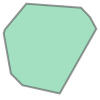

In [9]:
def random_polygon(
    radius_mean: float = 2,
    radius_sigma: float = 1.5,
):
    """Generates the simplest of polygons, a triangle with a size described by a random polygon.

    Args:
        radius_mean: The average radius defining a circumcircle of a triangle.
        radius_sigma: The variance of a radius defining a circumcircle of a triangle.

    Returns:
        A single triangle.
    """
    number_of_corners = np.random.randint(3, 10)
    array = polar_to_cartesian(
        np.random.lognormal(radius_mean, radius_sigma),
        np.sort(np.random.rand(number_of_corners)),
    )
    offset = np.random.randint(low=-SIZE_ROUTE, high=SIZE_ROUTE, size=(2,))
    return_values = np.zeros((number_of_corners, 2), dtype=float)
    # return_values[1, :] = np.real(offset)
    return_values[:] = offset
    return_values[:, :] += np.array((np.real(array), np.imag(array))).T
    return Polygon(return_values)
    # return np.array( + offset[0], np.imag(array) + offset[1])


np.random.seed(42)
random_polygon()

In [10]:
def generate_obstacles(
    seed=None,
    number_of_polygons: int = 40,
    radius_mean: float = 2,
    radius_sigma: float = 1,
) -> dict[str, Polygon]:
    """Generates a set of obstacles from a union of triangles.

    The union of triangles meas that if polygons overlap o polygon containing the union of those polygons is returned.
    Args:
        seed: A seed to generate a set of obstacles from.
        number_of_polygons: The number of polygons that should be drawn.
        radius_mean: The average radius defining a circumcircle of an obstacle triangle.
        radius_sigma: The variance of a radius defining a circumcircle of an obstacle triangle.

    Returns:
        A list of unified obstacles.
    """
    if seed is not None:
        np.random.seed(seed)
    polygons = []
    for _ in range(number_of_polygons):
        poly = random_polygon(radius_mean, radius_sigma)
        if poly.contains(Point(0, 0)):
            continue
        if poly.exterior.distance(Point(0, 0)) < 1:
            continue
        polygons.append(poly)
    polygon_list = list(unary_union(polygons).geoms)
    return {str(i): p for i, p in enumerate(polygon_list)}

In [11]:
def generate_destination(
    obstacles: dict[str, Polygon],
    seed: Optional[int] = None,
) -> Point:
    """Generates for a map.

    Can be used to generate a valid destination for list of obstacles.
    Args:
        obstacles: A list of obstacles.
        seed: The seed determining the point.

    Returns:
        A goal that should be reached by the ship.
    """
    # sets the seed
    if seed is not None:
        np.random.seed(seed)

    # generates the point
    point: Optional[Point] = None
    while (
        point is None
        or abs(point.x) < MIN_DESTINATION_DISTANCE
        or abs(point.y) < MIN_DESTINATION_DISTANCE
        or any(obstacle.contains(point) for obstacle in obstacles.values())
    ):
        point = Point(np.random.randint(-SIZE_INNER, SIZE_INNER, size=(2,), dtype=int))
    return point


print(generate_destination(generate_obstacles(42), 42))

POINT (-61 31)


In [12]:
def plot_situation(
    obstacles: dict[str, Polygon],
    destination: Point,
    obstacle_color: str | None = None,
    route: TimingFrame | np.ndarray | None = None,
    legend: bool = True,
    title: str | None = None,
) -> None:
    """PLots the obstacles into a matplotlib plot.

    Args:
        obstacles: A list of obstacles.
        destination: The destination that should be reached by the boat.
        obstacle_color: The color the obstacles should have. Can be None.
        If none all obstacles will have different colors.
        route: The route that should be plotted.
        legend: If true plots a legend.
        title: The title of the plot.
    Returns:
        None
    """
    # x.figure(figsize=(8, 8))
    # plt.axis([70.9481331655341 - 5, 70.9481331655341 + 5,  43.24219045432384-5, 43.24219045432384+5])
    plt.axis([-SIZE_ROUTE, SIZE_ROUTE, -SIZE_ROUTE, SIZE_ROUTE])

    # Sets a title if one is demanded
    if title:
        plt.title(title)

    # Plots the obsticles.
    if obstacles:
        for polygon in obstacles.values():
            if obstacle_color is not None:
                plt.fill(*polygon.exterior.xy, color=obstacle_color, label="Obstacle")
            else:
                plt.fill(*polygon.exterior.xy)

    # Plots the wind direction
    # https://www.geeksforgeeks.org/matplotlib-pyplot-arrow-in-python/
    plt.arrow(
        0,
        +int(SIZE_ROUTE * 0.9),
        0,
        -int(SIZE_ROUTE * 0.1),
        head_width=10,
        width=4,
        label="Wind (3Bft)",
    )

    if route is not None:
        if isinstance(route, TimingFrame):
            plt.plot(route.points[:, 0], route.points[:, 1], color="BLUE", marker=".")
        elif isinstance(route, np.ndarray):
            plt.plot(route[:, 0], route[:, 1], color="BLUE", marker=".")
        else:
            raise TypeError()

    # Plots the estination
    if destination:
        plt.scatter(*destination.xy, marker="X", color="green", label="Destination")
    plt.scatter(0, 0, marker="o", color="green", label="Start")

    if legend:
        # https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
    return None

In [13]:
if not NO_SHOW:
    plt.figure(figsize=(17.5, 25))
    for seed in tqdm(range(12)):
        plt.subplot(4, 3, seed + 1)
        generated_obstacles = generate_obstacles(seed)
        generated_destination = generate_destination(generated_obstacles, seed)
        route_generated = None

        # noinspection PyBroadException
        try:
            route_generated, _ = experiments.generate_route(
                position=Point(0, 0),
                goal=generated_destination,
                obstacles=generated_obstacles,
                wind=(18, 180),
            )
        except Exception:
            route_generated = None

        plot_situation(
            obstacles=generated_obstacles,
            destination=generated_destination,
            obstacle_color="RED",
            route=route_generated,
            title=f"Seed: {seed}, Cost: {route_generated.cost:.3f}",
            legend=seed == 0,
        )
    plt.show()

In [14]:
def generate_image_from_map(
    obstacles: dict[str, Polygon],
    destination: Point,
    route_type: Literal["line", "dot"],
    route: np.ndarray | TimingFrame | None = None,
    seed=None,
) -> Image:
    """Generate an image from the map.

    Can be used to feed an ANN.
    - Obstacles are marked as reed.
    - The destination is marked as green.
    - The points where the route will likely change are blue.

    Args:
        obstacles: A dict of obstacles as shapely Polygons. Keyed as a string.
        destination: A destination that should be navigated to.
    """
    img = Image.new(
        "RGB",
        (IMG_SIZE, IMG_SIZE),
        "#000000",
    )
    draw = ImageDraw.Draw(img)
    for polygon in obstacles.values():
        draw.polygon(
            list(
                (np.dstack(polygon.exterior.xy).reshape((-1)) + SIZE_ROUTE)
                / (2 * SIZE_ROUTE)
                * IMG_SIZE
            ),
            fill="#FF0000",
            outline="#FF0000",
        )
    if isinstance(route, TimingFrame):
        route = route.points
    route = ((route + SIZE_ROUTE) / (2 * SIZE_ROUTE) * IMG_SIZE).astype(int)
    if route_type == "line":
        draw.line([tuple(point) for point in route], fill=(0, 0, 0xFF))
    elif route_type == "dot":
        for point in route[1:]:
            try:
                img.putpixel(point, (0, 0, 0xFF))
            except IndexError:
                if seed:
                    print(f"Seed: {seed}, Point: {point}")
                return None
        pass
    else:
        raise ValueError("Route type unknown.")
    img.putpixel(
        (
            int((destination.x + SIZE_ROUTE) / (2 * SIZE_ROUTE) * IMG_SIZE),
            int((destination.y + SIZE_ROUTE) / (2 * SIZE_ROUTE) * IMG_SIZE),
        ),
        (0, 0xFF, 0),
    )
    return img

In [15]:
def generate_example_image(route_type: Literal["line", "dot"]):
    obstacles = generate_obstacles(42)
    destination = generate_destination(obstacles, 42)
    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, 180),
        )
    except Exception as e:
        route = None
    return generate_image_from_map(
        obstacles=obstacles,
        destination=destination,
        route=route,
        route_type=route_type,
    )

In [16]:
if not NO_SHOW:
    generate_example_image(route_type="dot").resize(
        (IMG_SHOW_SIZE, IMG_SHOW_SIZE), Image.Resampling.BICUBIC
    ).show()

In [17]:
if not NO_SHOW:
    generate_example_image(route_type="line").resize(
        (IMG_SHOW_SIZE, IMG_SHOW_SIZE), Image.Resampling.BICUBIC
    ).show()

In [18]:
if not NO_SHOW:
    seed = 42
    wind_dir = 180
    generated_obstacles = generate_obstacles(seed)
    generated_destination = generate_destination(generated_obstacles, seed)
    route_generated = None
    route_generated, _ = experiments.generate_route(
        position=Point(0, 0),
        goal=generated_destination,
        obstacles=generated_obstacles,
        wind=(18, wind_dir),
    )

In [19]:
if not NO_SHOW:
    for seed in tqdm([42]):
        plt.figure(figsize=(8, 8))
        wind_dir = 180
        generated_obstacles = generate_obstacles(seed)
        generated_destination = generate_destination(generated_obstacles, seed)
        route_generated = None
        try:
            route_generated, _ = experiments.generate_route(
                position=Point(0, 0),
                goal=generated_destination,
                obstacles=generated_obstacles,
                wind=(18, wind_dir),
            )
        except Exception as e:
            route_generated = None
        plot_situation(
            obstacles=generated_obstacles,
            destination=generated_destination,
            obstacle_color="RED",
            route=route_generated,
            title=f"Seed: {seed}, Cost: {route_generated.cost:.3f}",
            legend=seed == 0,
        )
        plt.show()

In [20]:
def generate_all_to_series(
    seed: Optional[int] = None, image: bool = False
) -> pd.Series:
    """Generates everything and aggregates all data into a `pd:Series`.

    Args:
        seed:The seed that should be used to generate map and destination.
        image: If an image should be generated or if that should be postponed to save memory.
    Returns:
        Contains a `pd.Series`containing the following.
        - The seed tha generated the map.
        - The destination in x
        - The destination in y
        - A list of Obstacle polygons.
        - The route generated for this map by the roBOOTer navigation system.
        - Optionally the image containing all the information.
          Can be generated at a later date without the fear for a loss of accuracy.
    """
    obstacles = generate_obstacles(seed)
    destination = generate_destination(obstacles, seed)

    try:
        route, _ = experiments.generate_route(
            position=Point(0, 0),
            goal=destination,
            obstacles=obstacles,
            wind=(18, wind_dir),
        )
    except Exception as e:
        print("Error")
        print(e)
        route = None
    return pd.Series(
        data={
            "seed": str(seed),
            "obstacles": obstacles,
            "destination_x": destination.x,
            "destination_y": destination.y,
            "image": generate_image_from_map(obstacles, destination, route)
            if image
            else pd.NA,
            "route": route.points if route else pd.NA,
            "cost": route.cost if route else pd.NA,
        },
        name=str(seed),
    )

In [21]:
if not NO_SHOW:
    df = pd.DataFrame(
        [generate_all_to_series(i, image=False) for i in tqdm(range(2))]
    ).set_index("seed")
    df.to_pickle("test.pickle")
    df

https://programtalk.com/python-examples/PIL.ImageDraw.Draw.polygon/)
https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask

In [ ]:
```python
save_frequency = int(os.getenv("save_frequency", "50"))
start_seed = int(os.getenv("seed_start", "0"))
continues = bool(os.getenv("continues", "false"))

files = glob.glob("data/*.pickle")
seed_groups = {int(file[9:-7]) for file in files}
for next_seeds in range(start_seed, 10_000_000_000, save_frequency):
    if next_seeds in seed_groups:
        continue
    print(f"Start generating routes for seed: {next_seeds}")
    tmp_pickle_str: str = f"data/tmp_{next_seeds:010}.pickle"
    pd.DataFrame().to_pickle(tmp_pickle_str)
    df = pd.DataFrame(
        [
            generate_all_to_series(i, image=False)
            for i in tqdm(range(next_seeds, next_seeds + save_frequency, 1))
        ]
    ).set_index("seed")
    pickle_to_file = f"data/raw_{next_seeds:010}.pickle"
    df.to_pickle(pickle_to_file)
    os.remove(tmp_pickle_str)
    if not continues:
        break
```

In [22]:
DATA_COLECTION_PATH: Final[str] = "data/collected.pickle"
if os.path.exists(DATA_COLECTION_PATH) and not GENERATE_NEW:
    collected_data = pd.read_pickle(DATA_COLECTION_PATH)
else:
    collected_data = pd.concat(
        [
            pd.read_pickle(filename)
            for filename in tqdm(glob.glob("data/raw_*.pickle")[:NUMBER_OF_FILES_LIMIT])
        ]
    )
    number_of_maps = len(collected_data.index)
    print(f"{number_of_maps: 10} maps collected")
    collected_data.dropna(subset=["route"], inplace=True)
    number_of_routes = len(collected_data.index)
    print(f"{number_of_routes: 10} routes collected")
    collected_data.to_pickle(DATA_COLECTION_PATH)
collected_data

  0%|          | 0/1000 [00:00<?, ?it/s]

     50000 maps collected
     43400 routes collected


obstacles  destination_x  \
seed                                                                      
0      {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
1      {'0': POLYGON ((-97.82715137072381 -82.2211677...          -38.0   
2      {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
3      {'0': POLYGON ((-7.4210414351932155 -83.111096...           31.0   
4      {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
...                                                  ...            ...   
50045  {'0': POLYGON ((-86.63193290264695 -93.5319244...           69.0   
50046  {'0': POLYGON ((2.518895755683328 -96.87282498...          -71.0   
50047  {'0': POLYGON ((-4.460598846031621 -99.2649725...          -36.0   
50048  {'0': POLYGON ((-90.6998307775452 -75.58510795...          -48.0   
50049  {'0': POLYGON ((-73.30908588454162 -74.1477834...          -48.0   

       destination_y image                                              route  \
seed                                                                            
0              -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
1               65.0  <NA>                        [[0.0, 0.0], [-38.0, 65.0]]   
2               49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
3               56.0  <NA>  [[0.0, 0.0], [5.303962239032221, 10.6856391688...   
4               54.0  <NA>  [[0.0, 0.0], [4.691900284503645, -5.4114328014...   
...              ...   ...                                                ...   
50045          -61.0  <NA>  [[0.0, 0.0], [-9.17985022292322, 0.74185570341...   
50046          -58.0  <NA>  [[0.0, 0.0], [-54.61671323674942, -33.84002165...   
50047          -47.0  <NA>                       [[0.0, 0.0], [-36.0, -47.0]]   
50048          -42.0  <NA>                       [[0.0, 0.0], [-48.0, -42.0]]   
50049           72.0  <NA>  [[0.0, 0.0], [-8.34785332097252, 2.56320973960...   

               cost  
seed                 
0        100.151629  
1      75292.761936  
2      18967.522925  
3      63200.630758  
4      28914.654143  
...             ...  
50045     695.38234  
50046     67.928607  
50047     36.544878  
50048     37.990761  
50049  34269.035908  

[43400 rows x 6 columns]

# find and drop all routes that exit the map!

In [23]:
def check_route_in_bounds(route):

    # easier to debut in multiple lines
    if route is None:
        return False
    if route is pd.NA:
        return False
    if not isinstance(route, np.ndarray):
        return False
    if np.array(
        abs(route) > 100,
    ).any():
        return False
    return True


data_before = len(collected_data.index)

df_filter = collected_data["route"].mapply(check_route_in_bounds)
filtered = collected_data[~df_filter]
collected_data = collected_data[df_filter]

data_after = len(collected_data.index)

print(
    f"{data_before} - {data_before-data_after} = {data_after} sets of data remaining."
)
del data_before, data_after, filtered, df_filter

  0%|          | 0/43 [00:00<?, ?it/s]

43400 - 188 = 43212 sets of data remaining.


# find and drop all routes with errors!


In [24]:
def check_route_self_crossing(route):
    if isinstance(route, float):
        print(float)
    return not LineString(route).is_simple


data_before = len(collected_data.index)
collected_data = collected_data[
    ~collected_data["route"].mapply(check_route_self_crossing)
]
data_after = len(collected_data.index)
print(
    f"{data_before} - {data_before-data_after} = {data_after} sets of data remaining."
)
del data_before, data_after

  0%|          | 0/43 [00:00<?, ?it/s]

43212 - 2759 = 40453 sets of data remaining.


# distribution over costs and points in rutes routes!

In [25]:
QUNATILE_LIMIT: Final[float] = 0.95
if "DATA_UPPER_LIMIT_QUANTIL" not in locals():
    DATA_UPPER_LIMIT_QUANTIL: Final[float] = collected_data["cost"].quantile(
        QUNATILE_LIMIT
    )
    OVER_QUANTILE: Final[int] = int(len(collected_data.index) * (1 - QUNATILE_LIMIT))
print(
    f"{OVER_QUANTILE} entries over the {QUNATILE_LIMIT} quantile at {DATA_UPPER_LIMIT_QUANTIL:.3f}"
)

2022 entries over the 0.95 quantile at 39839.307


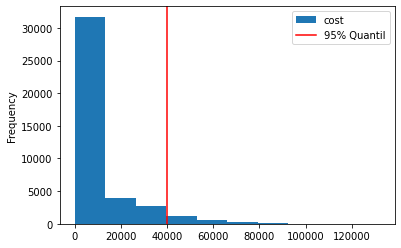

In [26]:
collected_data["cost"].plot.hist(bins=10, log=False)  # find a drop limit
plt.axvline(x=DATA_UPPER_LIMIT_QUANTIL, color="RED", label="95% Quantil")
plt.legend()
plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

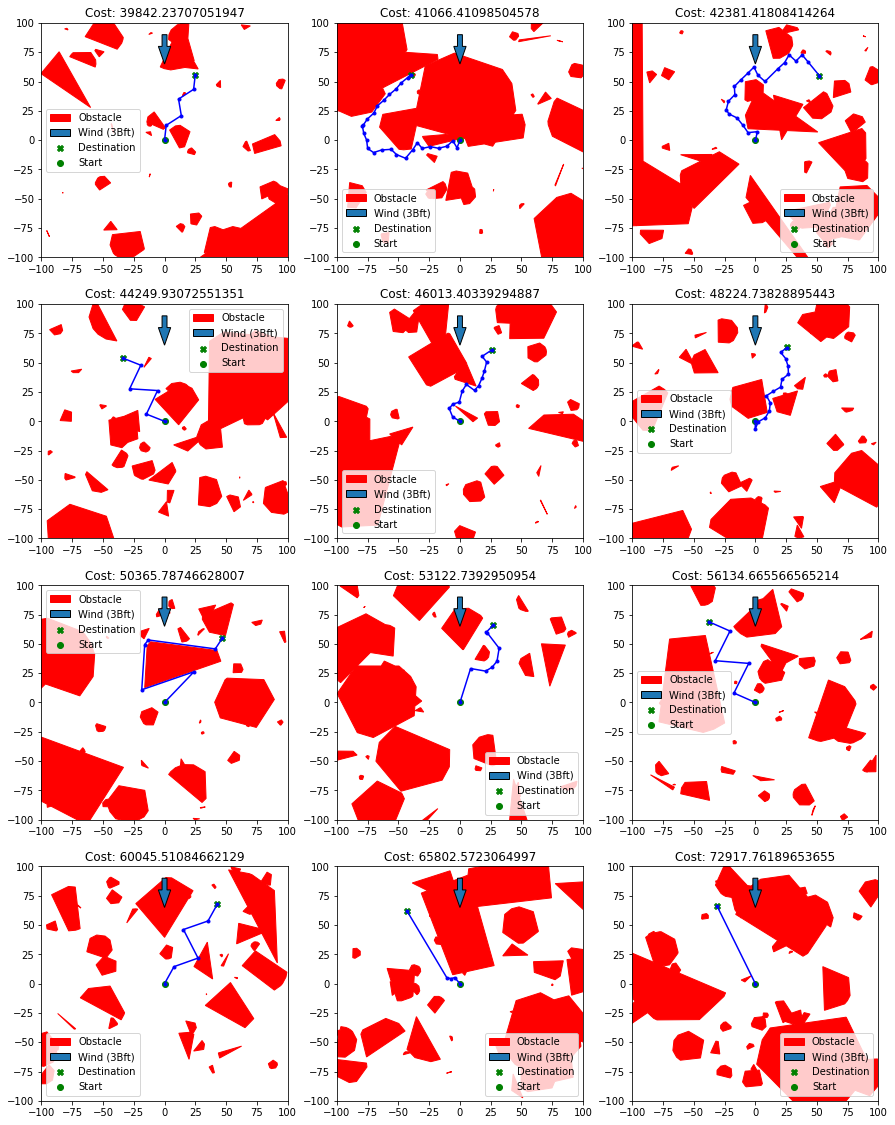

In [27]:
plt.figure(figsize=(15, 25))
for count, (seed, row) in tqdm(
    enumerate(
        collected_data[collected_data["cost"] > DATA_UPPER_LIMIT_QUANTIL]
        .sort_values("cost")
        .iloc[0 :: int(OVER_QUANTILE / 12)]
        .iloc[:12]
        .iterrows()
    ),
    total=12,
):
    plt.subplot(5, 3, count + 1)
    plot_situation(
        destination=Point(row.destination_x, row.destination_y),
        obstacles=row.generated_obstacles,
        obstacle_color="RED",
        route=row.route_generated,
        title=f"Cost: {row.cost}",
    )
plt.show()

In [28]:
collected_data = collected_data.loc[collected_data["cost"] < DATA_UPPER_LIMIT_QUANTIL]
collected_data

obstacles  destination_x  \
seed                                                                      
0      {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
2      {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
4      {'0': POLYGON ((-77.97638439917915 -70.2390972...           47.0   
5      {'0': POLYGON ((-71.45682729091783 -138.627922...          -67.0   
6      {'0': POLYGON ((-76.20025009472265 -92.9434076...          -67.0   
...                                                  ...            ...   
50045  {'0': POLYGON ((-86.63193290264695 -93.5319244...           69.0   
50046  {'0': POLYGON ((2.518895755683328 -96.87282498...          -71.0   
50047  {'0': POLYGON ((-4.460598846031621 -99.2649725...          -36.0   
50048  {'0': POLYGON ((-90.6998307775452 -75.58510795...          -48.0   
50049  {'0': POLYGON ((-73.30908588454162 -74.1477834...          -48.0   

       destination_y image                                              route  \
seed                                                                            
0              -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
2               49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
4               54.0  <NA>  [[0.0, 0.0], [4.691900284503645, -5.4114328014...   
5               37.0  <NA>  [[0.0, 0.0], [-42.539218405821984, 15.14880405...   
6               55.0  <NA>  [[0.0, 0.0], [-7.80975254664349, 3.41866699781...   
...              ...   ...                                                ...   
50045          -61.0  <NA>  [[0.0, 0.0], [-9.17985022292322, 0.74185570341...   
50046          -58.0  <NA>  [[0.0, 0.0], [-54.61671323674942, -33.84002165...   
50047          -47.0  <NA>                       [[0.0, 0.0], [-36.0, -47.0]]   
50048          -42.0  <NA>                       [[0.0, 0.0], [-48.0, -42.0]]   
50049           72.0  <NA>  [[0.0, 0.0], [-8.34785332097252, 2.56320973960...   

               cost  
seed                 
0        100.151629  
2      18967.522925  
4      28914.654143  
5        186.095369  
6      23898.229531  
...             ...  
50045     695.38234  
50046     67.928607  
50047     36.544878  
50048     37.990761  
50049  34269.035908  

[38430 rows x 6 columns]

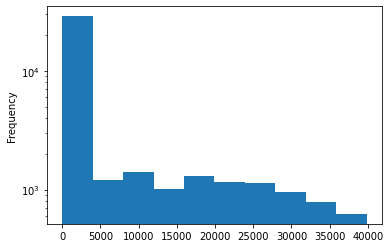

In [29]:
collected_data["cost"].plot.hist(log=True)
plt.show()

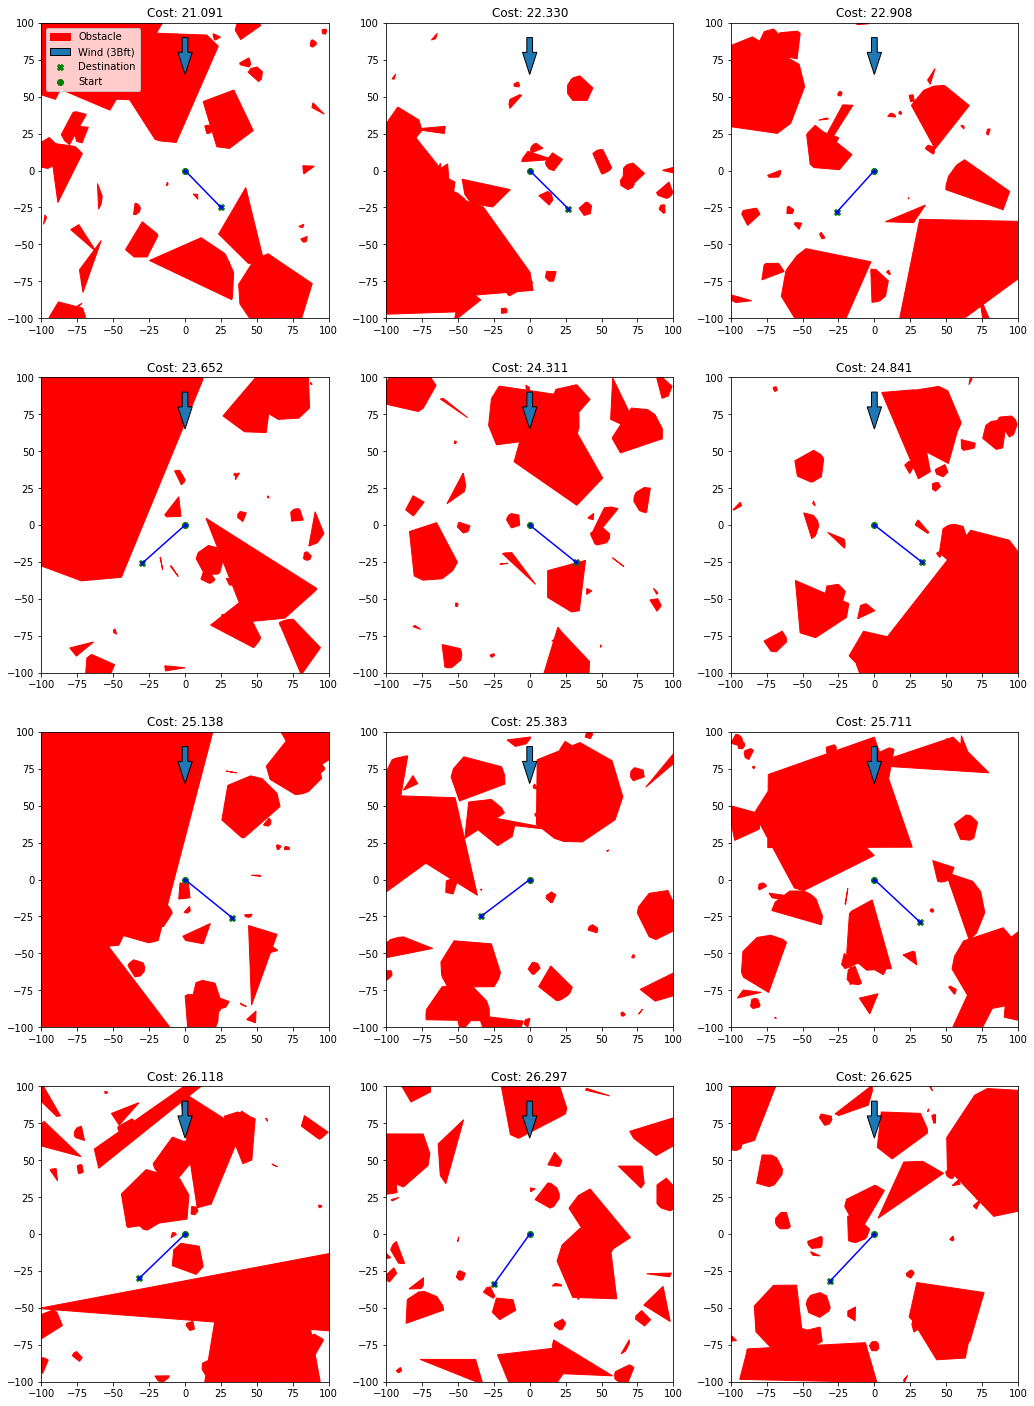

In [30]:
collected_data[collected_data["cost"] < DATA_UPPER_LIMIT_QUANTIL]

plt.figure(figsize=(17.5, 25))
for count, (seed, row) in enumerate(
    collected_data[collected_data["cost"] < DATA_UPPER_LIMIT_QUANTIL]
    .sort_values("cost")
    .iloc[1:600:51]
    .iterrows()
):
    plt.subplot(4, 3, count + 1)
    plot_situation(
        destination=Point(row.destination_x, row.destination_y),
        obstacles=row.generated_obstacles,
        obstacle_color="RED",
        route=row.route_generated,
        title=f"Cost: {row.cost:.3f}",
        legend=count == 0,
    )
plt.show()

# Visualize Complexity

In [31]:
def get_route_points(data):
    df = data["route"].apply(lambda r: r.shape[0] - 1)
    df.name = "route complexity"
    return df


route_points = get_route_points(collected_data)

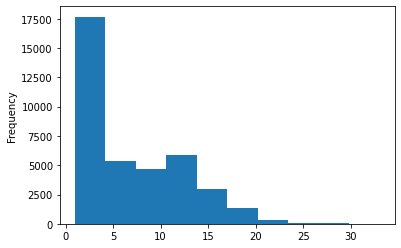

In [32]:
route_points.plot.hist()
plt.show()

In [33]:
routes_before = len(collected_data.index)
collected_data = collected_data[route_points <= 15]
routes_after = len(collected_data.index)
print(
    f"{routes_before} - {routes_before - routes_after} = {routes_after} "
    f"if only routes with less then 15 course changes remain."
)

38430 - 2451 = 35979 if only routes with less then 15 course changes remain.


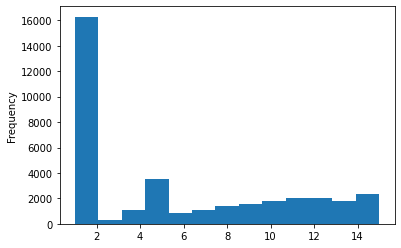

In [34]:
get_route_points(collected_data).plot.hist(bins=13)
plt.show()

In [35]:
get_route_points(collected_data).value_counts().sort_index()

1     15146
2      1139
3       331
4      1056
5      3490
6       826
7      1070
8      1389
9      1554
10     1764
11     2028
12     2067
13     1791
14     1333
15      995
Name: route complexity, dtype: int64

# Dropping routes that are to easy 

In [36]:
LIMIT_SIMPLE_CASES = 0.05
values = get_route_points(collected_data).value_counts().sort_index()
chance_limit = (
    (len(collected_data.index) * LIMIT_SIMPLE_CASES * (1 - LIMIT_SIMPLE_CASES))
    / values.get(1, 1)
    if 1 in values.index
    else 1
)
print(
    f"Limiting simple cases to {LIMIT_SIMPLE_CASES * 100:.1f}% of the total routes. Reducing simple routes to {(chance_limit * 100):.1f}% of theire volume."
)

Limiting simple cases to 5.0% of the total routes. Reducing simple routes to 11.3% of theire volume.


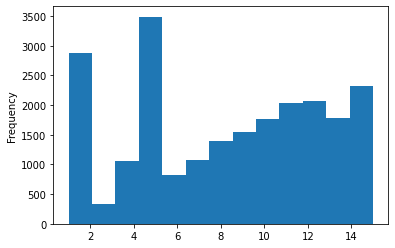

In [37]:
collected_data = collected_data[
    (
        (get_route_points(collected_data) > 1)
        | (np.random.random(len(collected_data.index)) < chance_limit)
    )
]
get_route_points(collected_data).plot.hist(bins=13)
plt.show()

In [38]:
get_route_points(collected_data).value_counts().sort_index()

1     1744
2     1139
3      331
4     1056
5     3490
6      826
7     1070
8     1389
9     1554
10    1764
11    2028
12    2067
13    1791
14    1333
15     995
Name: route complexity, dtype: int64

In [39]:
collected_data

obstacles  destination_x  \
seed                                                                      
0      {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
2      {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
5      {'0': POLYGON ((-71.45682729091783 -138.627922...          -67.0   
7      {'0': POLYGON ((10.806865516434499 -102.670968...           67.0   
8      {'0': POLYGON ((-38.740101054728726 -89.986420...           58.0   
...                                                  ...            ...   
50039  {'0': POLYGON ((-80.21298069840438 -87.2502584...           74.0   
50041  {'0': POLYGON ((-18.017612906524075 -91.647295...          -28.0   
50043  {'0': POLYGON ((-55.5210778390028 -66.95232495...           47.0   
50046  {'0': POLYGON ((2.518895755683328 -96.87282498...          -71.0   
50049  {'0': POLYGON ((-73.30908588454162 -74.1477834...          -48.0   

       destination_y image                                              route  \
seed                                                                            
0              -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
2               49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
5               37.0  <NA>  [[0.0, 0.0], [-42.539218405821984, 15.14880405...   
7              -52.0  <NA>  [[0.0, 0.0], [10.886352485821806, -16.87002927...   
8               61.0  <NA>  [[0.0, 0.0], [-8.211437427025228, -1.293253961...   
...              ...   ...                                                ...   
50039           31.0  <NA>  [[0.0, 0.0], [5.67318252835214, -5.67318252835...   
50041          -36.0  <NA>  [[0.0, 0.0], [-20.01287183186477, -22.10557708...   
50043           28.0  <NA>  [[0.0, 0.0], [3.868462226776941, 3.86846222677...   
50046          -58.0  <NA>  [[0.0, 0.0], [-54.61671323674942, -33.84002165...   
50049           72.0  <NA>  [[0.0, 0.0], [-8.34785332097252, 2.56320973960...   

               cost  
seed                 
0        100.151629  
2      18967.522925  
5        186.095369  
7         63.479684  
8      16899.906926  
...             ...  
50039   5162.824624  
50041      36.50201  
50043    284.832436  
50046     67.928607  
50049  34269.035908  

[22577 rows x 6 columns]

In [40]:
del chance_limit

# Memory consumption

In [41]:
collected_data

obstacles  destination_x  \
seed                                                                      
0      {'0': POLYGON ((-17.62168766659423 -98.3692662...          -66.0   
2      {'0': POLYGON ((-46.23706006792075 -76.7569948...           73.0   
5      {'0': POLYGON ((-71.45682729091783 -138.627922...          -67.0   
7      {'0': POLYGON ((10.806865516434499 -102.670968...           67.0   
8      {'0': POLYGON ((-38.740101054728726 -89.986420...           58.0   
...                                                  ...            ...   
50039  {'0': POLYGON ((-80.21298069840438 -87.2502584...           74.0   
50041  {'0': POLYGON ((-18.017612906524075 -91.647295...          -28.0   
50043  {'0': POLYGON ((-55.5210778390028 -66.95232495...           47.0   
50046  {'0': POLYGON ((2.518895755683328 -96.87282498...          -71.0   
50049  {'0': POLYGON ((-73.30908588454162 -74.1477834...          -48.0   

       destination_y image                                              route  \
seed                                                                            
0              -54.0  <NA>  [[0.0, 0.0], [-6.514627334268863, -5.502693040...   
2               49.0  <NA>  [[0.0, 0.0], [43.20648551245758, 31.2114102262...   
5               37.0  <NA>  [[0.0, 0.0], [-42.539218405821984, 15.14880405...   
7              -52.0  <NA>  [[0.0, 0.0], [10.886352485821806, -16.87002927...   
8               61.0  <NA>  [[0.0, 0.0], [-8.211437427025228, -1.293253961...   
...              ...   ...                                                ...   
50039           31.0  <NA>  [[0.0, 0.0], [5.67318252835214, -5.67318252835...   
50041          -36.0  <NA>  [[0.0, 0.0], [-20.01287183186477, -22.10557708...   
50043           28.0  <NA>  [[0.0, 0.0], [3.868462226776941, 3.86846222677...   
50046          -58.0  <NA>  [[0.0, 0.0], [-54.61671323674942, -33.84002165...   
50049           72.0  <NA>  [[0.0, 0.0], [-8.34785332097252, 2.56320973960...   

               cost  
seed                 
0        100.151629  
2      18967.522925  
5        186.095369  
7         63.479684  
8      16899.906926  
...             ...  
50039   5162.824624  
50041      36.50201  
50043    284.832436  
50046     67.928607  
50049  34269.035908  

[22577 rows x 6 columns]

In [42]:
def generate_image_maps(row, route_type: Literal["dot", "line"]):
    img = np.expand_dims(
        np.asarray(
            generate_image_from_map(
                obstacles=row.generated_obstacles,
                destination=Point(row.destination_x, row.destination_y),
                route=row.route_generated,
                route_type=route_type,
                seed=row.name,
            )
        ),
        axis=0,
    )
    img = img // 0xFF
    return img


generated = collected_data.head().apply(generate_image_maps, axis=1, args=("dot",))
humanize.naturalsize(generated.memory_usage(deep=True))

'246.8 kB'

In [43]:
if "image" in collected_data.columns:
    del collected_data["image"]

In [44]:
DATA_WITH_IMG_PATH: Final[str] = "data/collected_and_filtered.pickle"
if os.path.exists(DATA_WITH_IMG_PATH) and not GENERATE_NEW:
    collected_data = pd.read_pickle(DATA_WITH_IMG_PATH)
else:
    collected_data.to_pickle(DATA_WITH_IMG_PATH)

In [45]:
image_series = collected_data.progress_apply(
    generate_image_maps, axis=1, args=("line",)
)

#  collected_data["image_lines"] = collected_data.apply(
#      generate_image_maps, axis=1, args=("line",)
#  )

  0%|          | 0/22577 [00:00<?, ?it/s]

In [46]:
collected_routes = np.concatenate(image_series)
del image_series

In [47]:
humanize.naturalsize(sys.getsizeof(collected_routes))

'1.1 GB'

In [48]:
collected_routes.dtype

dtype('uint8')

In [49]:
memory = sorted(
    [
        (x, sys.getsizeof(globals().get(x)))
        for x in dir()
        if not x.startswith("_") and x not in sys.modules
    ],
    key=lambda x: x[1],
    reverse=True,
)
memory = {name: humanize.naturalsize(mem) for name, mem in memory[:10]}
memory

{'collected_routes': '1.1 GB',
 'collected_data': '27.4 MB',
 'route_points': '2.7 MB',
 'generated': '246.9 kB',
 'row': '2.0 kB',
 'CartesianRoute': '1.1 kB',
 'LineString': '1.1 kB',
 'Point': '1.1 kB',
 'TimingFrame': '1.1 kB',
 'Polygon': '904 Bytes'}

In [50]:
COLLECTED_ROUTES_DUMP = "data/collected_routes_np.pickle"
with open(COLLECTED_ROUTES_DUMP, "wb") as f:
    pickle.dump(collected_routes, f)

# with open(COLLECTED_ROUTES_DUMP,'rb') as f: collected_routes = pickle.load(f)

[Pix2Pix Tensorflow](https://www.tensorflow.org/tutorials/generative/pix2pix)

In [51]:
# Source: https://www.tensorflow.org/tutorials/generative/pix2pix
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


downsample(64, 4)

2022-07-12 22:54:12.025009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-12 22:54:12.025051: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-12 22:54:12.025069: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6c2cdca2902f): /proc/driver/nvidia/version does not exist
2022-07-12 22:54:12.025335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [52]:
collected_routes[0].shape

(128, 128, 3)

In [53]:
tf.expand_dims(collected_routes[0], 0).shape

TensorShape([1, 128, 128, 3])

In [54]:
down_model = downsample(3, 4)
tf.cast(tf.expand_dims(collected_routes[1], 0), "float16", name=None)

down_result = down_model(
    tf.cast(tf.expand_dims(collected_routes[1], 0), "float16", name=None)
)
print(down_result.shape)

(1, 64, 64, 3)


In [55]:
# Source: https://www.tensorflow.org/tutorials/generative/pix2pix
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [56]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
up_result.shape

TensorShape([1, 128, 128, 3])

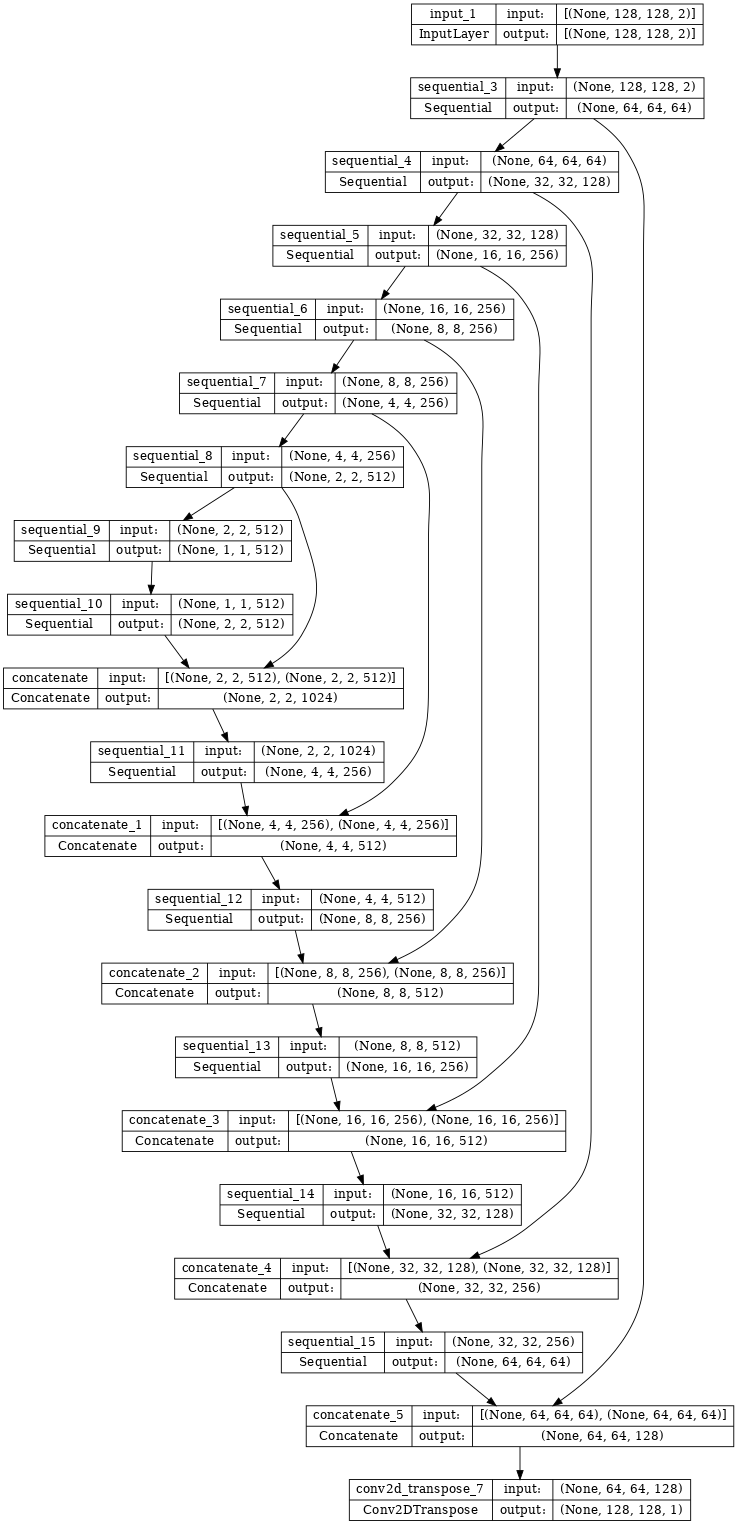

In [57]:
def Generator():
    OUTPUT_CHANNELS: Final[int] = 1
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 2])

    # down_stack = [
    #    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 128)
    #    downsample(128, 4),  # (batch_size, 8, 8, 512)
    #    downsample(512, 4),  # (batch_size, 4, 4, 512)
    #    downsample(512, 4),  # (batch_size, 2, 2, 512)
    #    downsample(512, 4),  # (batch_size, 1, 1, 512)
    #    downsample(512, 4),  # (batch_size, 1, 1, 512)
    #    downsample(512, 4),  # (batch_size, 1, 1, 512)
    # ]
    #
    # up_stack = [
    #    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    #    upsample(128, 4),  # (batch_size, 32, 32, 512)
    #    upsample(64, 4),  # (batch_size, 64, 64, 256)
    # ]

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 64, 64, 128)
        downsample(128, 4),  # (batch_size, 8, 8, 512)
        downsample(256, 4),  # (batch_size, 4, 4, 512)
        downsample(256, 4),  # (batch_size, 2, 2, 512)
        downsample(256, 4),  # (batch_size, 1, 1, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(256, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(256, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(256, 4),  # (batch_size, 16, 16, 1024)
        upsample(128, 4),  # (batch_size, 32, 32, 512)
        upsample(64, 4),  # (batch_size, 64, 64, 256)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        4,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh",
    )  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [58]:
!pip install pydot

In [59]:
!pip install pydotplus

In [60]:
generator.compile(
    optimizer=tf.keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss="mean_squared_error",
    # tf.keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[
        "binary_crossentropy",
        "mean_squared_error",
        "mean_absolute_error",
    ],  # root_mean_squared_error
)

In [61]:
tqdm_callback = tfa.callbacks.TQDMProgressBar(
    leave_epoch_progress=False, leave_overall_progress=True, show_epoch_progress=True
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="mean_squared_error",
    min_delta=0.0005,
    patience=2,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

tf_board = tf.keras.callbacks.TensorBoard(
    log_dir="./log_dir",
    histogram_freq=100,
    write_graph=False,
    write_images=False,
    write_steps_per_second=True,
    update_freq="epoch",
    profile_batch=(20, 40),
    embeddings_freq=0,
    embeddings_metadata=None,
)

reduce_learing_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="some metric", factor=0.2, patience=5, min_lr=000.1, verbose=1
)

NameError: name 'tfa' is not defined

In [ ]:
plt.figure(figsize=(17.5, 25))
np_array = np.flip(collected_routes[1, :, :, :], axis=0)

for chanel in tqdm(range(3)):
    plt.subplot(1, 4, chanel + 1)
    plt.imshow(np_array[:, :, chanel], interpolation="nearest")
plt.subplot(1, 4, 4)
plt.imshow(0x88 * np_array[:, :, 0] + 0xFF * np_array[:, :, 2], interpolation="nearest")
plt.show()

In [ ]:
collected_routes[:, :, :, :2].shape

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (collected_routes[:, :, :, :2], collected_routes[:, :, :, 2])
)
# test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

In [ ]:
train_dataset

In [ ]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
history = generator.fit(
    train_dataset,
    epochs=20,
    batch_size=512,
    use_multiprocessing=True,
    workers=5,
    callbacks=[early_stop, tf_board],
    # tqdm_callback,
)

In [ ]:
plt.plot(history.history["loss"])

In [ ]:
collected_routes[0:1, :, :, :2].shape

In [ ]:
predicted = generator.predict(
    collected_routes[:100, :, :, :2],
    batch_size=None,
    verbose="auto",
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=3,
    use_multiprocessing=True,
)

In [ ]:
predicted.shape

In [ ]:
plt.imshow(predicted[1, :, :, 0], interpolation="nearest")
plt.show()

In [ ]:
for pos in range(5):
    plt.imshow(
        predicted[pos, :, :, 0] * 0xFF + collected_routes[pos, :, :, 0] * 20,
        interpolation="nearest",
    )
    plt.show()

In [ ]:
# tf.keras.utils.plot_model(generator)

In [ ]:
@article{article,
author = {Jang, Hoyun and Lee, Inwon and Seo, Hyoungseock},
year = {2017},
month = {09},
pages = {4109-4117},
title = {Effectiveness of CFRP rudder aspect ratio for scale model catamaran racing yacht test},
volume = {31},
journal = {Journal of Mechanical Science and Technology},
doi = {10.1007/s12206-017-0807-8}
}

Ich würde auch zu 1. tendieren, stimme Ihnen aber zu, dass das Thema sehr umfangreich ist. Könnte man sich nicht einen Teilbereich herauspicken? Ich verstehe nicht viel vom Segeln, daher lassen Sie mich kurz zusammenfassen, was Sie vorhaben: - Sie generieren Trainingsdaten mit dem existierenden aber langsamen GD Algorithmus. Ich nehme an, es handelt sich um lokale Routen in einem relativ kleinen Kartenausschnitt. Lässt es die Laufzeit zu, dass Sie eine große Menge an Routen berechnen. - Sie haben dann eine Karte und als Ausgabe eine Liste der Wendepunkte - Warum wollen Sie daraus eine Heatmap berechnen? Diesen Schritt habe ich noch nicht verstanden - Wenn Sie aus einer Karte eine Heatmap trainieren wollen und dafür genügend Beispiele haben, könnnten GANs hilfreich sein: https://arxiv.org/abs/1611.07004 Ich würde Ihnen raten, das Problem möglichst so zu reduzieren, dass es im Rahmen des Moduls noch handhabbar bleibt. Alles Weitere kann man sich auch für spätere Arbeiten aufbewahren. Das 2. Thema ist auch ok. Aber vielleicht nicht ganz so spannend. Ich überlasse Ihnen die Entscheidung. Freundliche Grüße Heiner Giefers